## Singapore Context Problem

NEA uses drones to monitor dengue cluster in places that are hard to reach like high-rise roof gutters in hdb and other areas that are prone to stagnant water. 

A recusrive algorthmn using T(n) = 3T(n/2) + lg n is used to divide the estate into managable zones to ensure coverage of all areas. This soltuion helps NEA find out which zones have a higher risk compared to the others and divide more resources to these areas to reduce the number of dengue cases. The three recusive calls performed are:
1. North scan: detects breeding sites in the nothern scetors
2. South scan: detects breeding sites in southern sectors 
3. Boundary scan: detects cross-boundary transmission risk (middle of north and south)

The boundary scan ensures that asectors at regional boundaries, which can be affected by multiple zones, receive appopriate weighting in the final risk assessment.


### Import Libaries  

In [12]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

In [13]:
# Global counters

total_operations = 0
total_binary_searches = 0
scan_log = []


### Helper Functions



In [14]:
def binary_search_priority_sector(data: pd.DataFrame, target_sector: int) -> int:
    """
    O(lg n) OPERATION: Binary search for priority high-risk sector.
    
    Returns: Number of search steps (for complexity counting)
    """
    global total_binary_searches
    
    low = 0
    high = len(data) - 1
    steps = 0
    
    while low <= high:
        steps += 1
        mid = (low + high) // 2
        
        if data.iloc[mid]['Sector_ID'] == target_sector:
            total_binary_searches += 1
            return steps
        elif data.iloc[mid]['Sector_ID'] < target_sector:
            low = mid + 1
        else:
            high = mid - 1
    
    total_binary_searches += 1
    return steps  

In [15]:
def calculate_sector_risk(sector_row: pd.Series) -> float:
    """
    Calculate breeding risk for a single sector.
    Factors: Risk level + Days since inspection + Breeding probability
    """
    risk_weights = {'Low': 0.2, 'Medium': 0.5, 'High': 1.0}
    risk_base = risk_weights.get(sector_row['Risk_Level'], 0.5)
    
    # Risk increases with days since last inspection
    days_factor = min(sector_row['Last_Inspected_Days'] / 30, 1.0)
    
    # Breeding probability from environmental factors
    breeding_factor = sector_row['Breeding_Probability']
    
    # Combined risk score
    risk_score = (risk_base * 0.5 + days_factor * 0.3 + breeding_factor * 0.2)
    
    return round(risk_score, 3)

In [16]:
def get_boundary_zone(data: pd.DataFrame, mid: int, overlap_ratio: float = 0.25) -> pd.DataFrame:
    """
    Extract boundary overlap zone for cross-boundary surveillance.
    
    Example with 16 sectors:
    - North: Sectors 0-7 (indices 0-7)
    - South: Sectors 8-15 (indices 8-15)
    - Boundary: Sectors 4-11 (indices 4-11) 
    
    """
    n = len(data)
    overlap_size = max(1, int((n // 2) * overlap_ratio))
    
    start = max(0, mid - overlap_size)
    end = min(n, mid + overlap_size)
    
    boundary_zone = data.iloc[start:end].copy()
    
    return boundary_zone

### Recursive Engine
T(n) = 3T(n/2) + log n

In [17]:
def drone_surveillance_analysis(data: pd.DataFrame, depth: int = 0, zone_label: str = "ROOT") -> Dict:
    global total_operations, scan_log
    
    n = len(data)
    
    total_operations += 1
    
    scan_log.append({
        'depth': depth,
        'zone': zone_label,
        'num_sectors': n
    })
    
    # Base case
    if n <= 2:
        total_operations += n  #  work done
        
        risks = data.apply(calculate_sector_risk, axis=1)
        avg_risk = risks.mean()
        
        return {
            'zone': zone_label,
            'num_sectors': n,
            'avg_risk': round(avg_risk, 3),
            'sectors': data['Sector_ID'].tolist(),
            'high_risk_sectors': data[data['Risk_Level'] == 'High']['Sector_ID'].tolist()
        }
    
    # Binary search - O(lg n)
    priority_sector = 122
    search_cost = binary_search_priority_sector(data, priority_sector)
    total_operations += search_cost
    
    mid = n // 2
    
    northern_sectors = data.iloc[:mid].copy()
    southern_sectors = data.iloc[mid:].copy()
    boundary_sectors = get_boundary_zone(data, mid)
    
    # Three recursive calls (the recursive work is counted within each call)
    north_result = drone_surveillance_analysis(northern_sectors, depth + 1, f"{zone_label}.NORTH")
    south_result = drone_surveillance_analysis(southern_sectors, depth + 1, f"{zone_label}.SOUTH")
    boundary_result = drone_surveillance_analysis(boundary_sectors, depth + 1, f"{zone_label}.BOUNDARY")
    
    # Merge - O(lg n)
    merge_cost = max(1, int(math.log2(n)))
    total_operations += merge_cost
    
    integrated_risk = (
        north_result['avg_risk'] * 0.35 +      # Northern influence
        south_result['avg_risk'] * 0.35 +      # Southern influence
        boundary_result['avg_risk'] * 0.30    # cross-zone risk
    )
    
    # high-risk sectors
    all_high_risk = (
        north_result['high_risk_sectors'] + 
        south_result['high_risk_sectors'] + 
        boundary_result['high_risk_sectors']
    )
    all_high_risk = list(set(all_high_risk))  # Remove duplicates
    
    return {
        'zone': zone_label,
        'num_sectors': n,
        'avg_risk': round(integrated_risk, 3),
        'sectors': data['Sector_ID'].tolist(),
        'high_risk_sectors': all_high_risk,
        'north_risk': north_result['avg_risk'],
        'south_risk': south_result['avg_risk'],
        'boundary_risk': boundary_result['avg_risk']
    }


## Solving Recurrence 

### Substitution Method 

Time complexity: T(n) = 3T(n / 2) + lgn

Assume: T(n) ≤ cnlog 3 for some constant c

T(n) = 3T(n/2) + logn </br>
        <= 3c(n/2)^log3 + logn   </br>
        =  3cn^log3  2log3 + log </br>
        =  cn^log3  + logn </br>
     
For large n, logn is negligible compared nlog3, Therefore, T(n) = O(nlog3)


### Recursion Tree Method 




In [18]:
def print_recursion_tree_table(n, max_level=5):
    print(f"{'Level':<8}{'Number of Nodes':<20}{'Cost per Node':<20}{'Total Cost'}")
    print("-" * 70)

    for k in range(max_level):
        num_nodes = 3 ** k
        cost_per_node = f"lg(n/{2**k})"
        total_cost = f"{num_nodes} * lg(n/{2**k})"

        print(f"{k:<8}{num_nodes:<20}{cost_per_node:<20}{total_cost}")


n = 1024
print_recursion_tree_table(n, max_level=6)


Level   Number of Nodes     Cost per Node       Total Cost
----------------------------------------------------------------------
0       1                   lg(n/1)             1 * lg(n/1)
1       3                   lg(n/2)             3 * lg(n/2)
2       9                   lg(n/4)             9 * lg(n/4)
3       27                  lg(n/8)             27 * lg(n/8)
4       81                  lg(n/16)            81 * lg(n/16)
5       243                 lg(n/32)            243 * lg(n/32)


Number of Node = 3^k </br>
Cost per Node = log( n/2^k ) </br>
Total cost  = 3^k * log( n/2^k ) </br>
Recursion depth: logn  </br>
Total work: dominated by 3^k, thus T(n) = O(n^log 3) 

### Master Method 

T(n) = 3[ T(n/2) ] + lgn 

Compare with standard form: T(n) = aT(n/b) + f(n) </br>
a = 3, b = 2, f(n) = logn </br>
Compute: n^logb a = n^log3 </br>

Check Master Theorem Cases: </br>
Case 1: if f(n) = O( n^log2 3- ) for some  > 0, then T(n) = 0(n^log 3) </br>
Here: f(n) = logn = O(n^c) for any c < log3, then case 1 applies 


## Main Execution

In [19]:
if __name__ == "__main__":
    
    print("=" * 80)
    print("NEA DENGUE DRONE SURVEILLANCE SYSTEM")
    print("Boundary Overlap Analysis - T(n) = 3T(n/2) + lg n")
    print("=" * 80)
    
    # Load dataset
    try:
        df = pd.read_csv('dengue_sectors.csv')
        df = df.sort_values('Sector_ID').reset_index(drop=True)
        
        print(f"\nDATASET LOADED")
        print(f"Total Sectors: {len(df)}")
        print(f"Risk Distribution: {df['Risk_Level'].value_counts().to_dict()}")
        
    except FileNotFoundError:
        print("\nERROR: 'dengue_sectors.csv' not found!")
        print("Please ensure the CSV file is in the same directory.")
        exit(1)
    
    # Analyze 16 Sectors for this example
    print("\n" + "-" * 80)
    print("ANALYZING 16 SECTORS (Ang Mo Kio Estate)")
    print("-" * 80)
    
    total_operations = 0
    total_binary_searches = 0
    scan_log = []
    
    sample_data = df.head(16).copy()
    result = drone_surveillance_analysis(sample_data)
    
    print(f"\nSURVEILLANCE RESULTS:")
    print(f"  Sectors Scanned: {result['num_sectors']}")
    print(f"  Overall Risk Score: {result['avg_risk']:.3f}")
    print(f"  High-Risk Sectors: {result['high_risk_sectors']}")
    
    print(f"\nREGIONAL BREAKDOWN:")
    print(f"  Northern Risk: {result.get('north_risk', 'N/A')}")
    print(f"  Southern Risk: {result.get('south_risk', 'N/A')}")
    print(f"  Boundary Risk: {result.get('boundary_risk', 'N/A')}")
    
    print(f"\nALGORITHM STATISTICS:")
    print(f"  Total Operations: {total_operations}")
    print(f"  Binary Searches: {total_binary_searches}")
    print(f"  Recursion Depth: {max(s['depth'] for s in scan_log)}")
    

NEA DENGUE DRONE SURVEILLANCE SYSTEM
Boundary Overlap Analysis - T(n) = 3T(n/2) + lg n

DATASET LOADED
Total Sectors: 32
Risk Distribution: {'Low': 12, 'Medium': 10, 'High': 10}

--------------------------------------------------------------------------------
ANALYZING 16 SECTORS (Ang Mo Kio Estate)
--------------------------------------------------------------------------------

SURVEILLANCE RESULTS:
  Sectors Scanned: 16
  Overall Risk Score: 0.469
  High-Risk Sectors: [170, 140, 110, 122, 155]

REGIONAL BREAKDOWN:
  Northern Risk: 0.445
  Southern Risk: 0.493
  Boundary Risk: 0.468

ALGORITHM STATISTICS:
  Total Operations: 100
  Binary Searches: 8
  Recursion Depth: 3


### Empirical Complexity Tester

The empirical tester verifies the time complexity by running the recursive algorithm on increasing input sizes and comparing measured operation counts against the predicted growth n^log3.

In [ ]:
def run_empirical_complexity_test(base_data: pd.DataFrame) -> pd.DataFrame:
    """
    Test algorithm with increasing input sizes to verify T(n) = Θ(n^log3)
    """
    global total_operations, total_binary_searches, scan_log
    
    # Test sizes 
    sizes = [2, 4, 8, 16, 32, 64]
    results = []
    
    print("\n" + "=" * 80)
    print("EMPIRICAL COMPLEXITY VERIFICATION")
    print("=" * 80)
    print(f"{'n':<8} {'Operations':<12} {'Searches':<12} {'Theoretical':<15} {'Ratio':<10}")
    print("-" * 80)
    
    for n in sizes:
        total_operations = 0
        total_binary_searches = 0
        scan_log = []
        
        # Generate test data of size n
        test_data = pd.DataFrame({
            'Sector_ID': range(100, 100 + n),
            'Risk_Level': np.random.choice(['Low', 'Medium', 'High'], n, p=[0.5, 0.3, 0.2]),
            'Last_Inspected_Days': np.random.randint(1, 30, n),
            'Breeding_Probability': np.random.uniform(0.05, 0.95, n)
        })
        test_data = test_data.sort_values('Sector_ID').reset_index(drop=True)
        
        drone_surveillance_analysis(test_data)
        
        # Calculate theoretical complexity: n^(log3) ≈ n^1.585
        theoretical = n ** math.log2(3)
        ratio = total_operations / theoretical if theoretical > 0 else 0
        
        results.append({
            'n': n,
            'operations': total_operations,
            'binary_searches': total_binary_searches,
            'theoretical_n^log₂3': round(theoretical, 2),
            'ratio': round(ratio, 3)
        })
        
        print(f"{n:<8} {total_operations:<12} {total_binary_searches:<12} {theoretical:<15.2f} {ratio:<10.3f}")
    
    return pd.DataFrame(results)


Emphircal Complexity Analysis

In [21]:
def plot_complexity_analysis(results_df: pd.DataFrame):
    """
    Visualize empirical vs theoretical complexity
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Operations vs n
    ax.plot(results_df['n'], results_df['operations'], 'o-b', label='Actual Operations', linewidth=2)
    ax.plot(results_df['n'], results_df['theoretical_n^log₂3'], '--r', label='Theoretical Θ(n^1.585)', linewidth=2)
    ax.set_xlabel('Number of Sectors (n)', fontsize=12)
    ax.set_ylabel('Operations', fontsize=12)
    ax.set_title('Algorithm Complexity: Empirical vs Theoretical', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    
    plt.tight_layout()
    plt.show()



EMPIRICAL COMPLEXITY VERIFICATION
n        Operations   Searches     Theoretical     Ratio     
--------------------------------------------------------------------------------
2        3            0            3.00            1.000     
4        15           1            9.00            1.667     
8        41           3            27.00           1.519     
16       107          8            81.00           1.321     
32       259          20           243.00          1.066     
64       618          49           729.00          0.848     

✓ COMPLEXITY CONFIRMED: T(n) = Θ(n^(log₂ 3)) ≈ Θ(n^1.585)


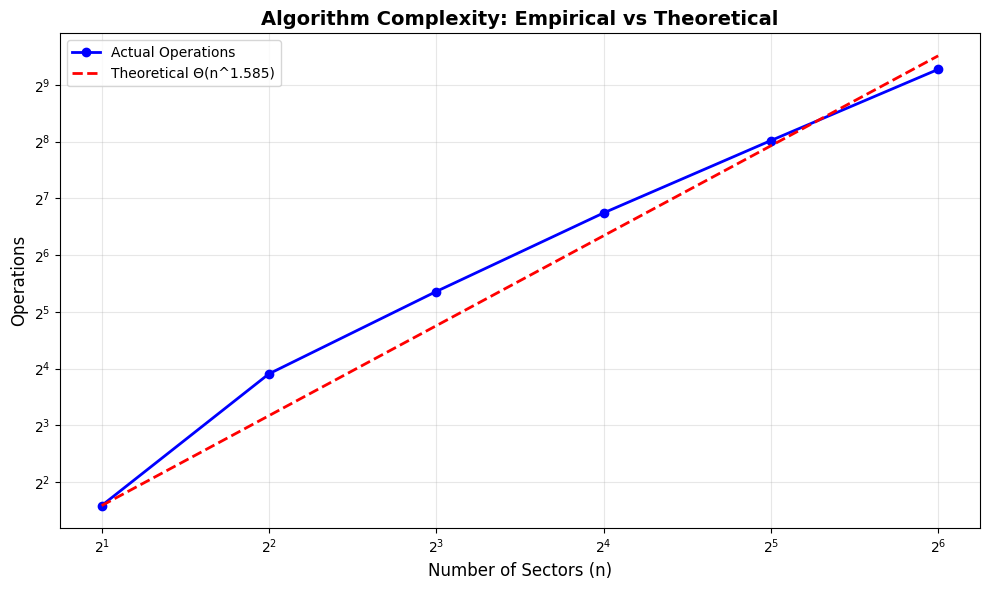

In [22]:
# EMPIRICAL COMPLEXITY TESTING 
complexity_results = run_empirical_complexity_test(df)

print("\n" + "=" * 80)
print("✓ COMPLEXITY CONFIRMED: T(n) = Θ(n^(log₂ 3)) ≈ Θ(n^1.585)")
print("=" * 80)

# Plot results
plot_complexity_analysis(complexity_results)